<a href="https://colab.research.google.com/github/zahrasultana2002/Insider-Threat-Detection/blob/main/usb_insertion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Count the number of times a USB was inserted per user
usb_insertions_df = df[df['from_removable_media'] > 0].groupby('user')['from_removable_media'].count().reset_index()

# Rename columns for clarity
usb_insertions_df.columns = ['User', 'USB_Insertions']

# Display the first few rows
print("USB Insertion Count per User:")
import ace_tools as tools
tools.display_dataframe_to_user(name="USB Insertions Count", dataframe=usb_insertions_df)


In [ ]:
def get_num_other_PC_per_week(user, user_pc, logon_data):
    weekly_pc_counts = defaultdict(set)  # Dictionary to store unique PCs per week
    all_weeks = set()  # Track all weeks where logins occurred

    for row in logon_data:
        logon_time = datetime.strptime(row[1], "%m/%d/%Y %H:%M:%S")  # Adjusted format
        week = logon_time.strftime("%Y-%W")  # Year-Week format
        all_weeks.add(week)  # Track all weeks

        if row[3] != user_pc:  # Check if PC is different from user's primary PC
            weekly_pc_counts[week].add(row[3])  # Add PC to the week's set (unique values only)

    # Ensure all weeks are included, even with 0 count
    min_week = min(all_weeks)
    max_week = max(all_weeks)

    # Generate all weeks between min and max
    start_date = datetime.strptime(min_week + "-1", "%Y-%W-%w")  # Convert to first day of the week
    end_date = datetime.strptime(max_week + "-1", "%Y-%W-%w")  # Convert to first day of the last week

    current_date = start_date
    complete_weeks = set()

    while current_date <= end_date:
        week_str = current_date.strftime("%Y-%W")
        complete_weeks.add(week_str)
        current_date += timedelta(days=7)  # Move to the next week

    # Ensure every week has a count (0 if no other PCs were accessed)
    weekly_counts = {
        week: len(weekly_pc_counts[week]) if week in weekly_pc_counts else 0
        for week in complete_weeks
    }

    # Convert to DataFrame with week as a proper datetime object
    output_list = [[user, datetime.strptime(week + "-1", "%Y-%W-%w"), count] for week, count in sorted(weekly_counts.items())]
    return pd.DataFrame(output_list, columns=["user", "week_start_date", "num_other_pc"])


In [ ]:
def label_insider_weeks(df, user, insider_root):
    """
    Adds an 'insider' column to the DataFrame by checking if the user's week exists in their insider file.

    :param df: DataFrame containing ['user', 'week_start_date', 'num_other_pc']
    :param user: The user ID for whom the dataframe is filtered.
    :param insider_root: Path to the folder containing multiple r5.2-* subfolders.
    :return: DataFrame with an 'insider' column.
    """

    # Locate the user's insider file
    insider_file = find_insider_answers_file(user, insider_root)

    # If no insider file exists for the user, mark all weeks as 0 (not insider)
    if not insider_file:
        df["insider"] = 0
        return df

    # Extract weeks from the insider CSV file
    insider_weeks = extract_weeks_from_csv(insider_file)

    # Convert insider weeks to datetime objects for proper comparison
    insider_weeks = {datetime.strptime(week + "-1", "%Y-%W-%w") for week in insider_weeks}

    # Label insider weeks in the user's dataframe
    df["insider"] = df["week_start_date"].apply(lambda w: 1 if w in insider_weeks else 0)

    return df


In [ ]:
print(labeled_df)

# Display first few rows in a readable format
import ace_tools as tools
tools.display_dataframe_to_user(name="Insider Weekly Activity", dataframe=labeled_df)


In [1]:
import pandas as pd

try:
    df = pd.read_csv('file.csv')
    display(df.head())
except FileNotFoundError:
    print("Error: 'file.csv' not found.")
    df = None
except pd.errors.ParserError:
    print("Error: Could not parse 'file.csv'. Check the file format.")
    df = None
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    df = None

,id,date,user,pc,filename,activity,to_removable_media,from_removable_media,content
0,{Y1W9-R7VJ77IC-9445QFNQ},01/02/2010 08:15:10,TSG0262,PC-9993,R:\79L99n6\H7RHJS5J.zip,File Open,False,True,50-4B-03-04-14 moved imaging underwent key lat...
1,{Y3U8-G5BL42LO-9404XAHI},01/02/2010 08:16:01,TSG0262,PC-9993,R:\79L99n6\H7RHJS5J.zip,File Open,False,True,50-4B-03-04-14 moved imaging underwent key lat...
2,{G6O2-V1BA89IL-9551VVVW},01/02/2010 08:16:18,TSG0262,PC-9993,R:\79L99n6\H7RHJS5J.zip,File Write,True,False,50-4B-03-04-14 visited immigrants plates day f...
3,{C7E2-M2KL43BA-8425WTXD},01/02/2010 08:16:47,TSG0262,PC-9993,R:\61Sj7N2\AIFSE2LN.doc,File Write,True,False,D0-CF-11-E0-A1-B1-1A-E1 increased star lower t...
4,{T5S8-H7KZ29BM-5254RFKH},01/02/2010 08:17:43,TSG0262,PC-9993,R:\79L99n6\H7RHJS5J.zip,File Write,True,False,50-4B-03-04-14 northwest british bay recalled ...


In [2]:
# Examine the shape of the data
print("Shape of the DataFrame:", df.shape)

# Check data types
print("\nData types of each column:\n", df.dtypes)

# Look for missing values
print("\nNumber of missing values in each column:\n", df.isnull().sum())

# Descriptive statistics for numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns
if len(numerical_cols) > 0:
    print("\nDescriptive statistics for numerical columns:\n", df[numerical_cols].describe())
else:
    print("\nNo numerical columns found.")

# Categorical variable exploration
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns
for col in categorical_cols:
    print(f"\nUnique values and frequencies for '{col}':\n{df[col].value_counts()}")

Shape of the DataFrame: (887621, 9)

Data types of each column:
 id                      object
date                    object
user                    object
pc                      object
filename                object
activity                object
to_removable_media        bool
from_removable_media      bool
content                 object
dtype: object

Number of missing values in each column:
 id                      0
date                    0
user                    0
pc                      0
filename                0
activity                0
to_removable_media      0
from_removable_media    0
content                 0
dtype: int64

No numerical columns found.

Unique values and frequencies for 'id':
id
{Y1W9-R7VJ77IC-9445QFNQ}    1
{Y3W2-Y6BL85MD-8689JTDT}    1
{J8G7-Y8FU78WT-1673WNRJ}    1
{E3B7-K8GF25YI-9464MOEY}    1
{E4F0-T8VJ42GK-8663ANXP}    1
                           ..
{Z8M8-S3UD37CD-7757TRFR}    1
{R5O7-Q3AG65FC-8359CMYS}    1
{P8S0-U4TO80WZ-6194APJN}    1
{N1A6-G8J

No numerical features found.


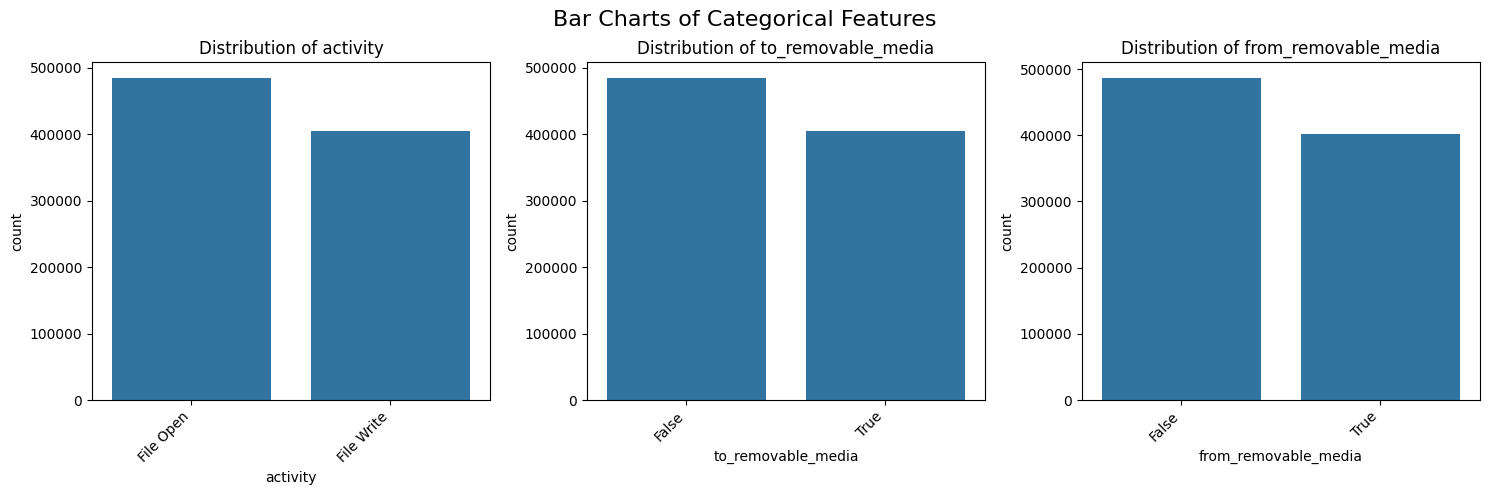

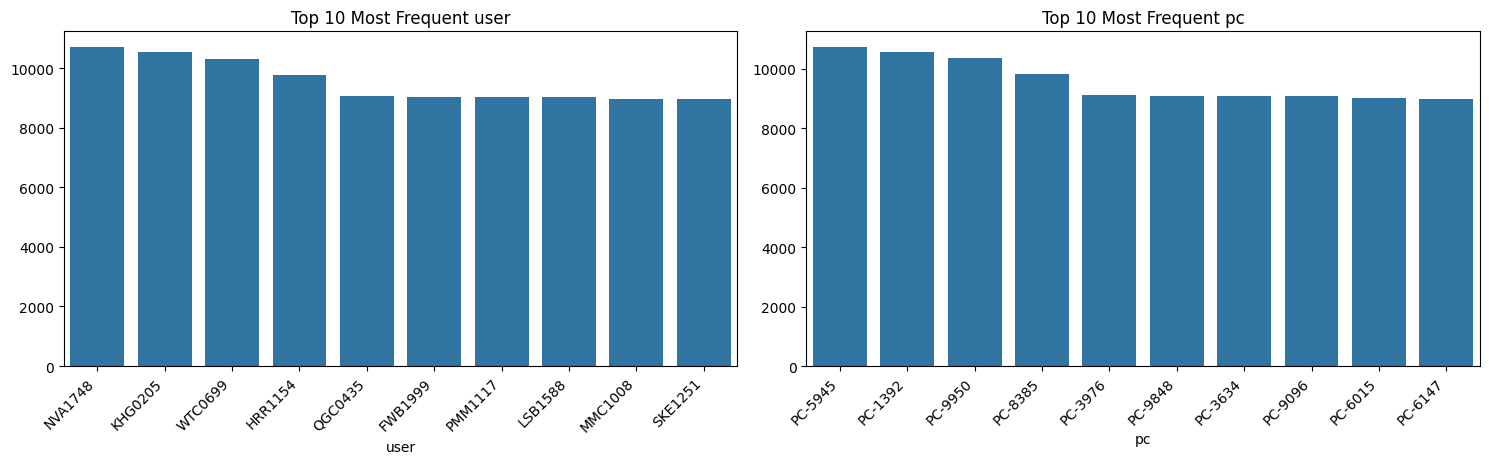

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check for numerical features and create histograms if any exist
numerical_cols = df.select_dtypes(include=['number']).columns
if len(numerical_cols) > 0:
    df[numerical_cols].hist(figsize=(10, 6), bins=20)
    plt.suptitle('Histograms of Numerical Features', fontsize=16)
    plt.show()
else:
    print("No numerical features found.")

# Bar charts for specified categorical features
categorical_cols = ['activity', 'to_removable_media', 'from_removable_media']
plt.figure(figsize=(15, 5))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, 3, i + 1)
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent title overlap
plt.suptitle('Bar Charts of Categorical Features', fontsize=16)
plt.show()

# Additional visualizations for other categorical variables
# Choose a few more categorical variables that might offer insights
additional_categorical_cols = ['user', 'pc']  # Example: user and pc
plt.figure(figsize=(15, 5))
for i, col in enumerate(additional_categorical_cols):
    plt.subplot(1, len(additional_categorical_cols), i + 1)
    value_counts = df[col].value_counts().nlargest(10) # show top 10 most frequent values
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f'Top 10 Most Frequent {col}')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [4]:
# 1. Analyze 'activity' in relation to removable media usage
activity_media_crosstab = pd.crosstab(df['activity'], [df['to_removable_media'], df['from_removable_media']])
display(activity_media_crosstab)

# 2. Investigate 'content' column for patterns (basic frequency analysis)
from collections import Counter

# Combine all content strings into a single string
all_content = ' '.join(df['content'].astype(str))

# Split the combined string into words
words = all_content.split()

# Count word frequencies
word_counts = Counter(words)

# Display the 10 most common words
display(word_counts.most_common(10))

# 3. Examine the relationship between 'user' and 'pc'
user_pc_counts = df.groupby('user')['pc'].value_counts().unstack(fill_value=0)
display(user_pc_counts.head(10))

to_removable_media    False           True 
from_removable_media  False   True    False
activity                                   
File Open             81819  401836       0
File Write                0       0  403966

[('D0-CF-11-E0-A1-B1-1A-E1', 549393),
 ('25-50-44-46-2D', 176565),
 ('prince', 159089),
 ('years', 57361),
 ('required', 55977),
 ('FF-D8', 55024),
 ('than', 51911),
 ('between', 51849),
 ('also', 51761),
 ('when', 51482)]

pc,PC-0010,PC-0014,PC-0021,PC-0026,PC-0040,PC-0048,PC-0059,PC-0060,PC-0063,PC-0065,...,PC-9962,PC-9967,PC-9972,PC-9981,PC-9983,PC-9984,PC-9991,PC-9993,PC-9994,PC-9999
user,,,,,,,,,,,,,,,,,,,,,
AAB1302,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAB1762,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAO1919,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAW0952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABB0019,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABC1881,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACA1126,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACM1770,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ADH0153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
